In [10]:
from tqdm import tqdm
import csv
import sys
csv.field_size_limit(sys.maxsize)
from collections import defaultdict
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
file="Data/author_contribution_full.csv"

In [3]:
term_mapping = {
    'introduction': 'Introduction',
    'background': 'Background',
    'related work': 'Related Work',
    'preliminaries': 'Preliminaries',
    'notation': 'Methods',
    'proofs': 'Methods',
    'methods': 'Methods',
    'method': 'Methods',
    'model': 'Methods',
    'the model': 'Methods',
    'methodology': 'Methods',
    'experiments': 'Experiments',
    'numerical experiments': 'Experiments',
    'numerical results': 'Results',
    'main results': 'Results',
    'results': 'Results',
    #'examples': 'Examples',  
    #'applications': 'Applications', 
    #'observations': 'Observations'
    #'summary': 'Summary',
    #'summary and conclusions': 'Summary and Conclusions',
    'conclusions': 'Conclusions',
    'conclusion': 'Conclusions',
    'concluding remarks': 'Conclusions',
    'discussion': 'Discussion',
    #'discussion and conclusions': 'Discussion and Conclusions',
    #'results and discussion': 'Results and Discussion',
    'acknowledgements': 'Acknowledgements',
    'acknowledgments': 'Acknowledgements',
    #'appendix': 'Appendix'
}

In [4]:
# Restructure data into paper-author-section units
t_df = []

with open(file,mode="r",encoding="utf-8") as FI:
     reader=csv.reader(FI)
     cols=next(reader)
     for row in tqdm(reader):
          
          # Exclude papers with invalid contribution records
          if row[cols.index("top_author")]=="":
               continue

          d = eval(re.sub(r"defaultdict\(<class 'int'>, (\{.*?\})\)", r"\1", row[cols.index('author_section_contribution')]))
          tt = [{term_mapping[k.lower()]:v for k,v in it.items() if k.lower() in term_mapping} for it in d.values()]
          total_contribution = sum(eval(row[cols.index('author_contribution')]).values()) + 1
          authors = [a for a in re.split(r', | and ', row[cols.index('authors')])]

          for i, (a, ac) in enumerate(d.items()):
               for s, c in ac.items():
                    if s.lower() in term_mapping:
                         item=[]
                         
                         # Basic information
                         item.append(row[cols.index("arxiv_id")]) # arxiv_id
                         item.append(row[cols.index("categories")]) # categories
                         item.append(row[cols.index("pub_year_from_open_alex")]) # pub_year_from_open_alex
                         item.append(a) # author
                         item.append(len(d)) # team_size_int
                         item.append(i+1) # author_order
                         # Contribution in full text
                         item.append(eval(row[cols.index('author_contribution')])[a]) # paper_contribution
                         item.append(eval(row[cols.index('author_contribution')])[a]/total_contribution) # paper_contribution_score
                         # Sectional contribution
                         item.append(term_mapping[s.lower()]) # sec
                         item.append(c) # sec_contribution
                         t = sum([it[term_mapping[s.lower()]] for it in tt if term_mapping[s.lower()] in it]) + 1
                         item.append(c/t) # sec_contribution_score
                         item.append(c / (sum(ac.values()) + 1)) # sec_contribution_score_normalized
                         
                         t_df.append(item)
          

2840569it [19:52, 2382.39it/s]


In [5]:
t_df=pd.DataFrame(t_df)
t_df.columns=(["arxiv_id","categories","pub_year_from_open_alex","author","team_size_int","author_order","paper_contribution","paper_contribution_score","sec","sec_contribution","sec_contribution_score","sec_contribution_score_normalized"])
t_df['domain'] = [it.split('.')[0] for it in t_df['categories']]
t_df['paper_contribution_log'] = np.log(t_df['paper_contribution'])
t_df['sec_contribution_log'] = np.log(t_df['sec_contribution'] + 1)
t_df['sec_contribution_score_log'] = np.log(t_df['sec_contribution_score'] + 1)
t_df['sec_contribution_score_normalized_log'] = np.log(t_df['sec_contribution_score_normalized'] + 1)

In [6]:
t_df

,arxiv_id,categories,pub_year_from_open_alex,author,team_size_int,author_order,paper_contribution,paper_contribution_score,sec,sec_contribution,sec_contribution_score,sec_contribution_score_normalized,domain,paper_contribution_log,sec_contribution_log,sec_contribution_score_log,sec_contribution_score_normalized_log
0,hep-ph/9609331,hep-ph,1996,Germany),5,4,96,0.989691,Introduction,0,0.000000,0.000000,hep-ph,4.564348,0.00000,0.000000,0.000000
1,hep-ph/9609331,hep-ph,1996,Germany),5,4,96,0.989691,Introduction,89,0.988889,0.193478,hep-ph,4.564348,4.49981,0.687576,0.176872
2,hep-ph/0407190,hep-ph,2004,S. Heinemeyer,5,2,3,0.750000,Introduction,0,0.000000,0.000000,hep-ph,1.098612,0.00000,0.000000,0.000000
3,hep-ph/0407190,hep-ph,2004,S. Heinemeyer,5,2,3,0.750000,Conclusions,0,0.000000,0.000000,hep-ph,1.098612,0.00000,0.000000,0.000000
4,hep-ph/0407190,hep-ph,2004,S. Heinemeyer,5,2,3,0.750000,Introduction,0,0.000000,0.000000,hep-ph,1.098612,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4063323,2303.10650,cs.LO cs.AI cs.LG,2023,Ekaterina Komendantskaya,4,2,3,0.750000,Background,0,0.000000,0.000000,cs,1.098612,0.00000,0.000000,0.000000
4063324,2303.10650,cs.LO cs.AI cs.LG,2023,Ekaterina Komendantskaya,4,2,3,0.750000,Acknowledgements,0,0.000000,0.000000,cs,1.098612,0.00000,0.000000,0.000000
4063325,2303.10650,cs.LO cs.AI cs.LG,2023,Ekaterina Komendantskaya,4,2,3,0.750000,Introduction,0,0.000000,0.000000,cs,1.098612,0.00000,0.000000,0.000000
4063326,2303.10650,cs.LO cs.AI cs.LG,2023,Ekaterina Komendantskaya,4,2,3,0.750000,Background,0,0.000000,0.000000,cs,1.098612,0.00000,0.000000,0.000000


In [14]:
# Key numbers
print(len(set(t_df["arxiv_id"])),len(set(t_df["author"])))
print(min(t_df[t_df["pub_year_from_open_alex"]!=""]["pub_year_from_open_alex"]),max(t_df[t_df["pub_year_from_open_alex"]!=""]["pub_year_from_open_alex"]))

414124 240034
1971 2024


# Figure 1: Hidden Division of Labor in Scientific Teams

In [7]:
# Filter data and prepare for regression
sel_sec = ['Introduction', 'Conclusions', 'Discussion', 'Acknowledgements',  # Conceptual sections
          'Methods', 'Results', 'Experiments', 'Preliminaries']  # Technical sections
data = t_df[(t_df['author_order'].isin([1,2, 3, 4, 5, 6, 7, 8])) & (t_df['sec'].isin(sel_sec))]

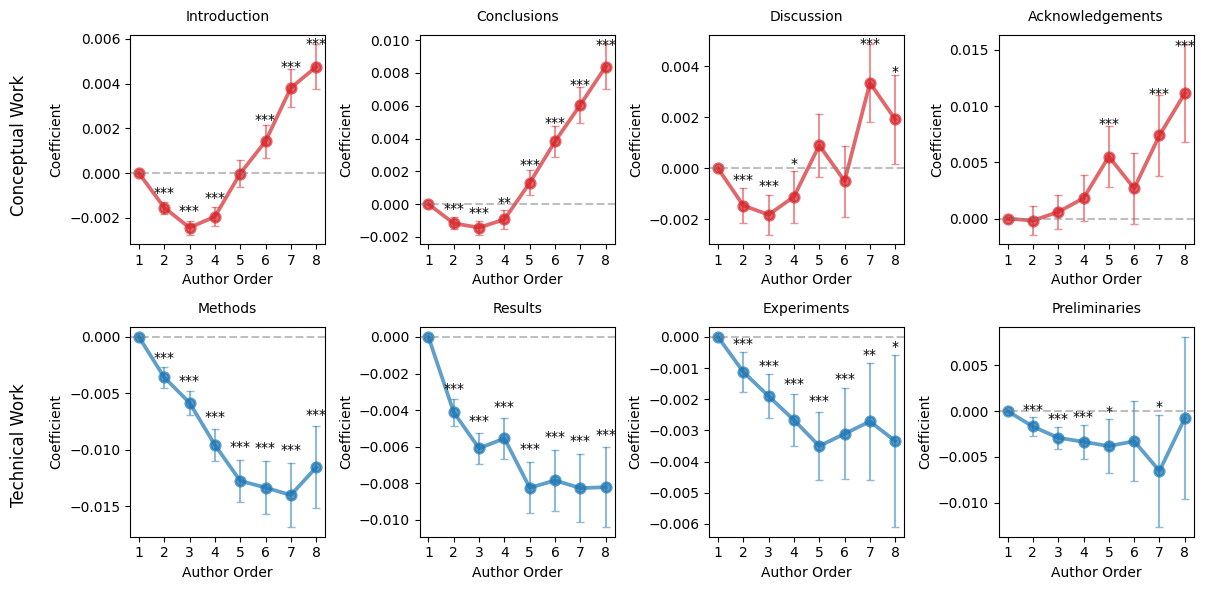

In [9]:
# Plotting

# Create figure with subplots for each section
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Add row labels
fig.text(0.0, 0.75, 'Conceptual Work', fontsize=12, rotation=90, va='center')
fig.text(0.0, 0.25, 'Technical Work', fontsize=12, rotation=90, va='center')

# Run separate OLS regressions for each section
for i, sec in enumerate(sel_sec):
    ax = axes[i]
    sec_data = data[data['sec']==sec]
    coef_data = []
    
    # Run OLS regression
    model = sm.OLS.from_formula('sec_contribution_score_normalized_log ~ C(author_order)', data=sec_data).fit()
    # Store coefficients and confidence intervals
    coef_data.append({
        'variable': 1,
        'coef': 0,
        'ci_lower': 0, 
        'ci_upper': 0,
        'pvalue': 1
    })   
    for j, var in enumerate(model.params.index):
        if 'C(author_order)' in var:
            coef_data.append({
                'variable': j + 1,
                'coef': model.params[var],
                'ci_lower': model.conf_int()[0][var],
                'ci_upper': model.conf_int()[1][var],
                'pvalue': model.pvalues[var]
            })
    # Convert to DataFrame
    coef_df = pd.DataFrame(coef_data)
    
    # Set color based on section type
    color = '#d6262b' if i < 4 else '#1d77b4'
    # Plot coefficients with different colors for conceptual vs technical
    sns.pointplot(data=coef_df, x='variable', y='coef', ax=ax, color=color, alpha=0.7)
    # Add confidence intervals with matching color
    ax.errorbar(x=range(len(coef_df)),
               y=coef_df['coef'],
               yerr=[coef_df['coef'] - coef_df['ci_lower'],
                     coef_df['ci_upper'] - coef_df['coef']],
               fmt='none', capsize=3, alpha=0.5,
               color=color)
    
    # Add significance stars
    for idx, row in coef_df.iterrows():
        stars = ''
        if row['pvalue'] < 0.001:
            stars = '***'
        elif row['pvalue'] < 0.01:
            stars = '**' 
        elif row['pvalue'] < 0.05:
            stars = '*'
        if stars:
            ax.text(idx, row['ci_upper']-0.05*row['ci_upper'], stars, ha='center', va='bottom')
    
    # Customize subplot
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax.set_xlabel('Author Order')
    ax.set_ylabel('Coefficient')
    ax.set_title(sec, fontsize=10, pad=10)

# Adjust layout to make room for row labels
plt.tight_layout() 
plt.subplots_adjust(left=0.1)

plt.savefig('Figures/Figure 1_Hidden Division of Labor in Scientific Teams.pdf',
            bbox_inches='tight')
plt.show()

# Figure 3: Declining Contribution with Author Order

In [12]:
# Filter data and prepare for regression
data = t_df[t_df['team_size_int']<=8].drop_duplicates(['arxiv_id','author'])
# Convert author_order to string type
data['author_order'] = data['author_order'].astype(str)

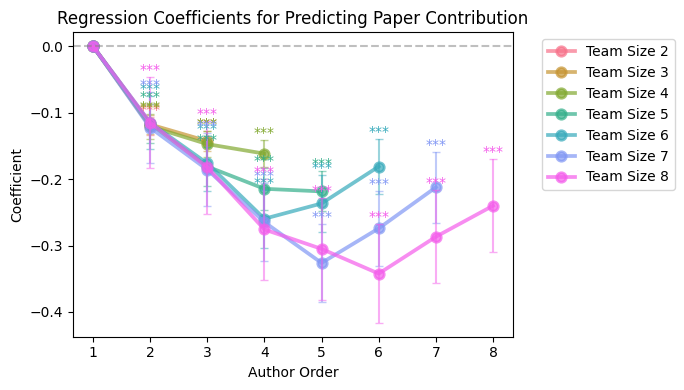

In [13]:
# Create figure
fig, ax = plt.subplots(figsize=(7, 4))

# Colors for different team sizes
colors = sns.color_palette("husl", n_colors=7)
# Run regression for each team size
for team_size, color in zip(range(2,9), colors):
    # Filter for this team size
    team_data = data[data['team_size_int']==team_size]
    
    # Run regression
    model = smf.ols(formula='paper_contribution_log ~ author_order + domain + team_size_int', data=team_data).fit()
    # Extract coefficients and confidence intervals for author order
    coef_data = []
    # Add intercept as author order 1
    coef_data.append({
        'variable': '1',
        'coef': 0,
        'ci_lower': 0,
        'ci_upper': 0,
        'pvalue': 1
    })
    for var in model.params.index:
        if var.startswith('author_order'):
            coef_data.append({
                'variable': var.replace('author_order[T.', '').replace(']',''),
                'coef': model.params[var],
                'ci_lower': model.conf_int()[0][var],
                'ci_upper': model.conf_int()[1][var],
                'pvalue': model.pvalues[var]
            })
    # Convert to DataFrame
    coef_df = pd.DataFrame(coef_data)
    
    # Plot coefficients and confidence intervals
    sns.pointplot(data=coef_df, x='variable', y='coef', color=color, 
                 label=f'Team Size {team_size}', ax=ax, alpha=0.7)
    # Add confidence intervals
    plt.errorbar(x=range(len(coef_df)), 
                y=coef_df['coef'],
                yerr=[coef_df['coef'] - coef_df['ci_lower'], 
                      coef_df['ci_upper'] - coef_df['coef']],
                fmt='none', color=color, capsize=3, alpha=0.5)

    # Add significance stars
    for idx, row in coef_df.iterrows():
        stars = ''
        if row['pvalue'] < 0.001:
            stars = '***'
        elif row['pvalue'] < 0.01:
            stars = '**'
        elif row['pvalue'] < 0.05:
            stars = '*'
        if stars:
            ax.text(idx, row['ci_upper'], stars, ha='center', va='bottom', color=color)

# Customize plot
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Author Order')
ax.set_ylabel('Coefficient')
ax.set_title('Regression Coefficients for Predicting Paper Contribution')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and save
plt.tight_layout()
plt.savefig('Figures/Figure 3_Declining Contribution with Author Order.pdf', bbox_inches='tight')
plt.show()

# Figure 4: Discipline-Specific Patterns in Author Order

In [21]:
top_domain = ['cs', 'econ']

In [22]:
# Count number of papers of each discipline
for i, domain in enumerate(top_domain):
    domain_data = t_df[
        (t_df['domain'] == domain) & 
        (t_df['team_size_int']<=8)
    ].drop_duplicates(['arxiv_id','author'])
    print(domain,len(set(domain_data.arxiv_id)))

cs 76749
econ 1194


/var/folders/15/zdzkyvk944j0nfbn1bqzyd2w0000gn/T/ipykernel_96460/207413809.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


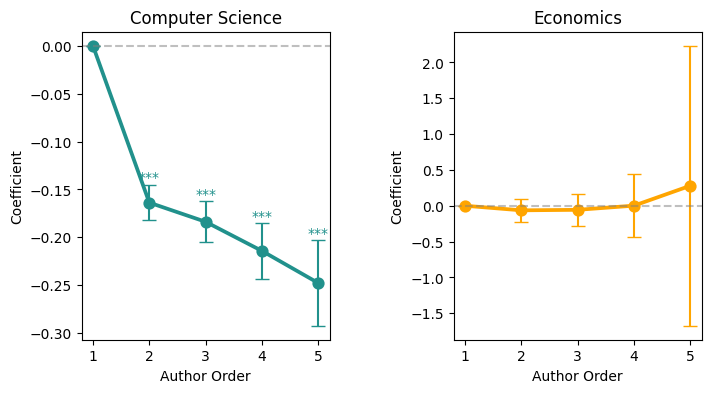

In [23]:
# Create figure to hold all domain plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'wspace': 0.5})
axes = axes.flatten()

# For each domain, run regression and create plot
for i, domain in enumerate(top_domain):
    
    # Filter data for this domain
    domain_data = t_df[
        (t_df['domain'] == domain) & 
        (t_df['team_size_int']<=5)
    ].drop_duplicates(['arxiv_id','author'])
    # Convert author_order to string type
    domain_data['author_order'] = domain_data['author_order'].astype(str)
    
    # Run OLS regression with team size
    model = smf.ols(
        formula='paper_contribution_log ~ author_order + team_size_int',
        data=domain_data
    ).fit()
    # Extract coefficients and confidence intervals
    coef_data = []
    # Add coefficient of 0 for order 1 (baseline)
    coef_data.append({
        'variable': '1',
        'coef': 0,
        'ci_lower': 0,
        'ci_upper': 0,
        'pvalue': 1
    })
    # Extract coefficients for author order
    for var in model.params.index:
        if var.startswith('author_order'):
            coef_data.append({
                'variable': var.replace('author_order[T.', '').replace(']',''),
                'coef': model.params[var],
                'ci_lower': model.conf_int()[0][var],
                'ci_upper': model.conf_int()[1][var],
                'pvalue': model.pvalues[var]
            })
    # Convert to DataFrame
    coef_df = pd.DataFrame(coef_data)
    
    # Plot coefficients and CIs
    color = 'orange' if domain == 'econ' else plt.cm.viridis(0.5)
    line = sns.pointplot(data=coef_df, x='variable', y='coef', color=color, ax=axes[i])
    axes[i].errorbar(x=range(len(coef_df)), 
                    y=coef_df['coef'],
                    yerr=[coef_df['coef'] - coef_df['ci_lower'], 
                          coef_df['ci_upper'] - coef_df['coef']],
                    fmt='none', color=color, capsize=5)
    
    # Add significance stars
    for idx, row in coef_df.iterrows():
        stars = ''
        if row['pvalue'] < 0.001:
            stars = '***'
        elif row['pvalue'] < 0.01:
            stars = '**'
        elif row['pvalue'] < 0.05:
            stars = '*'
        if stars:
            axes[i].text(idx, row['ci_upper'], stars, ha='center', va='bottom', color=color)
    
    # Customize subplot
    axes[i].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[i].set_xlabel('Author Order')
    axes[i].set_ylabel('Coefficient')
    
    # Use full domain names for titles
    domain_titles = {'cs': 'Computer Science', 'econ': 'Economics'}
    axes[i].set_title(domain_titles[domain])

plt.tight_layout()
plt.savefig('Figures/Figure 4_Discipline Specific Patterns in Author Order.pdf', bbox_inches='tight')
plt.show()